In [6]:
import pip

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, roc_auc_score, accuracy_score, f1_score

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

import pickle

In [3]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Spine-disease-exp')
mlflow.sklearn.autolog()

2025/07/23 20:24:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/23 20:24:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [3]:
df = pd.read_csv('./data/Dataset_spine.csv')
df.head()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [4]:
df.describe()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [5]:
df.shape

(310, 7)

In [6]:
df.isnull().sum()

pelvic incidence               0
 pelvic tilt                   0
 lumbar lordosis angle         0
 sacral slope                  0
 pelvic radius                 0
 grade of spondylolisthesis    0
Class_att                      0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pelvic incidence             310 non-null    float64
 1    pelvic tilt                 310 non-null    float64
 2    lumbar lordosis angle       310 non-null    float64
 3    sacral slope                310 non-null    float64
 4    pelvic radius               310 non-null    float64
 5    grade of spondylolisthesis  310 non-null    float64
 6   Class_att                    310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [8]:
df.columns

Index(['pelvic incidence', ' pelvic tilt', ' lumbar lordosis angle',
       ' sacral slope', ' pelvic radius', ' grade of spondylolisthesis',
       'Class_att'],
      dtype='object')

In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [10]:
df.columns

Index(['pelvic_incidence', '_pelvic_tilt', '_lumbar_lordosis_angle',
       '_sacral_slope', '_pelvic_radius', '_grade_of_spondylolisthesis',
       'class_att'],
      dtype='object')

In [11]:
df['class_att'].value_counts()

class_att
Abnormal    210
Normal      100
Name: count, dtype: int64

In [12]:
df['class_att'] = df['class_att'].map({'Abnormal': 0, 'Normal': 1}).astype(int)

EDA

Barplot of target variable

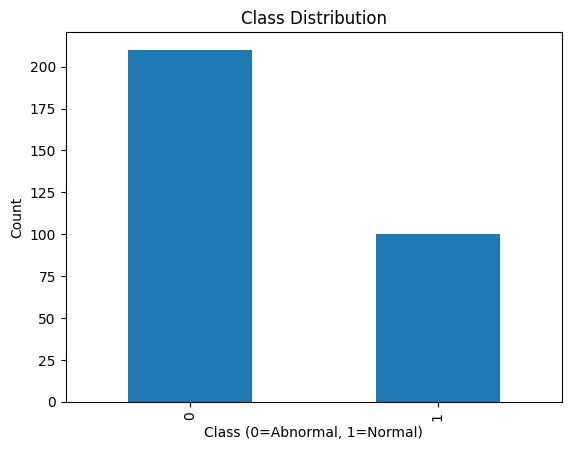

In [13]:
df['class_att'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0=Abnormal, 1=Normal)')
plt.ylabel('Count')
plt.show()

Histogram for each numerical feature to see their distributions.

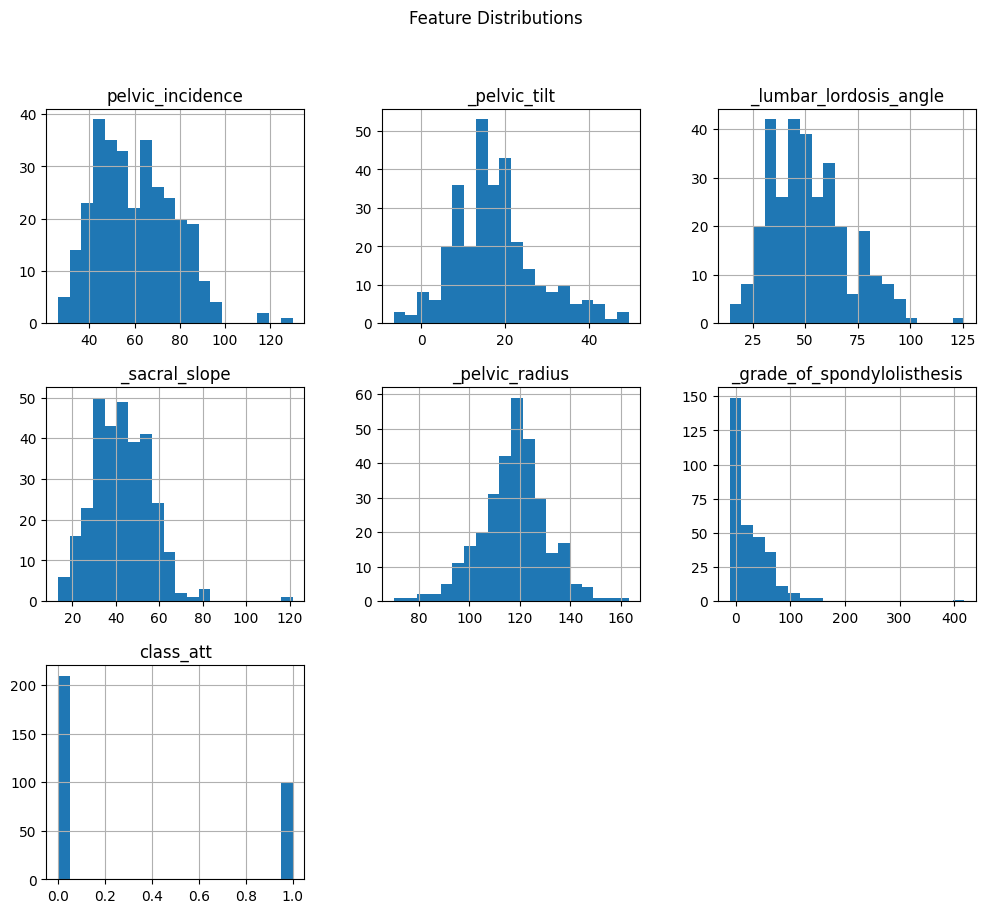

In [11]:
df.hist(bins=20, figsize=(12, 10))
plt.suptitle('Feature Distributions')
plt.show()

Boxplot to check for outliers and compare feature distributions across classes.

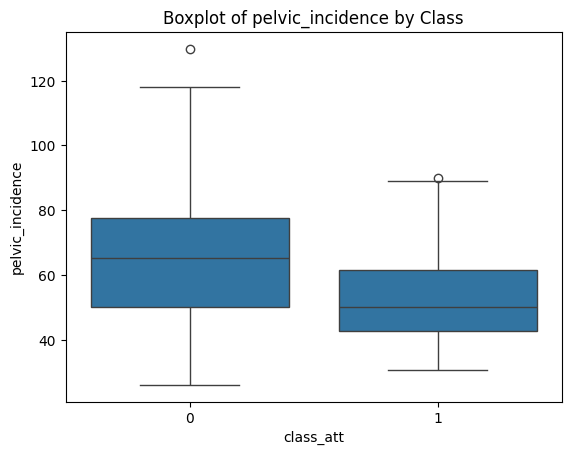

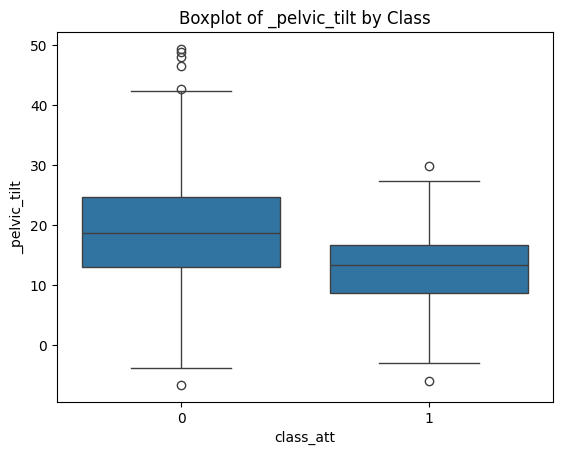

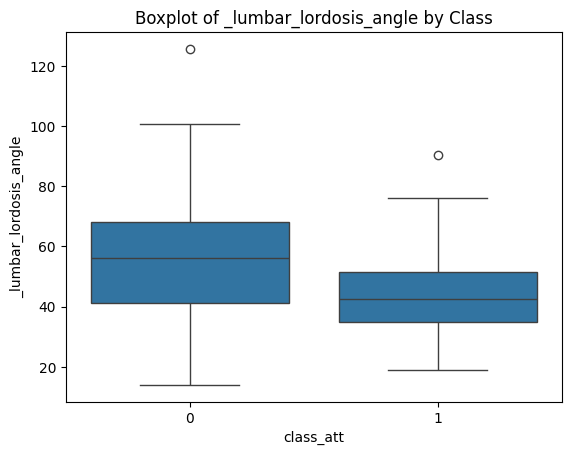

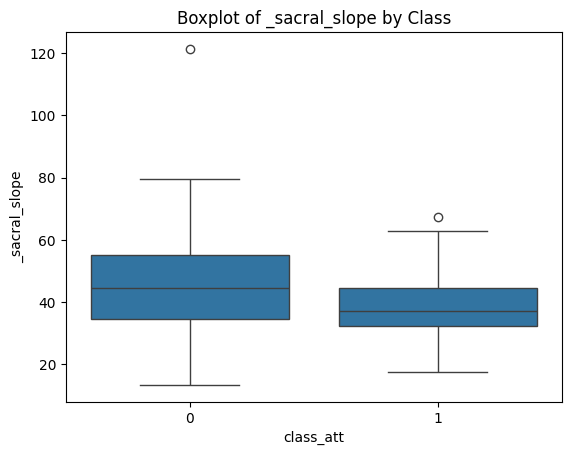

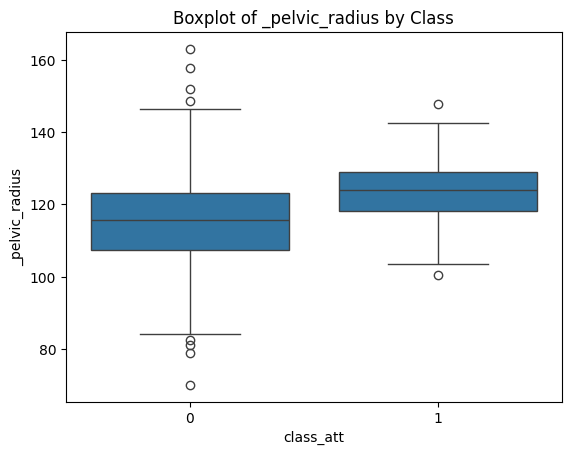

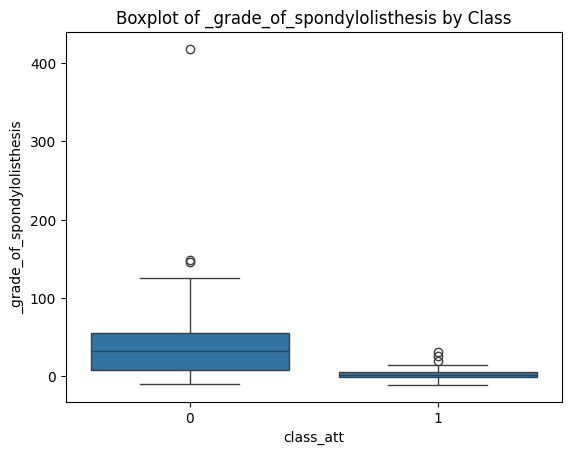

In [12]:
for col in df.columns[:-1]:  # Exclude class_att
    plt.figure()
    sns.boxplot(x='class_att', y=col, data=df)
    plt.title(f'Boxplot of {col} by Class')
    plt.show()

Correlation matric; Heatmap of the correlation matrix to see relationships between features.

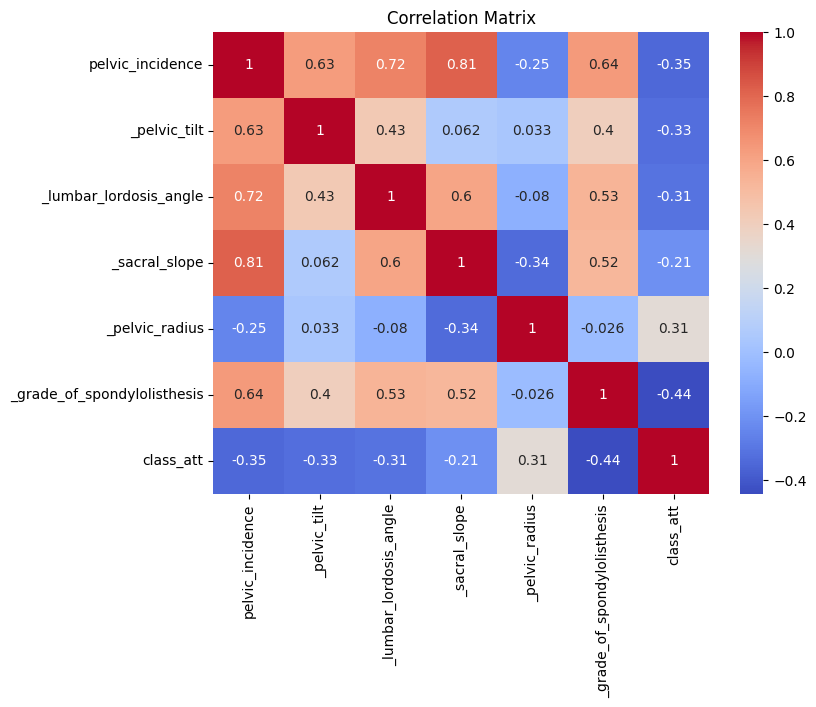

In [13]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Pairplot to visualize pairwise relationships and class separation.

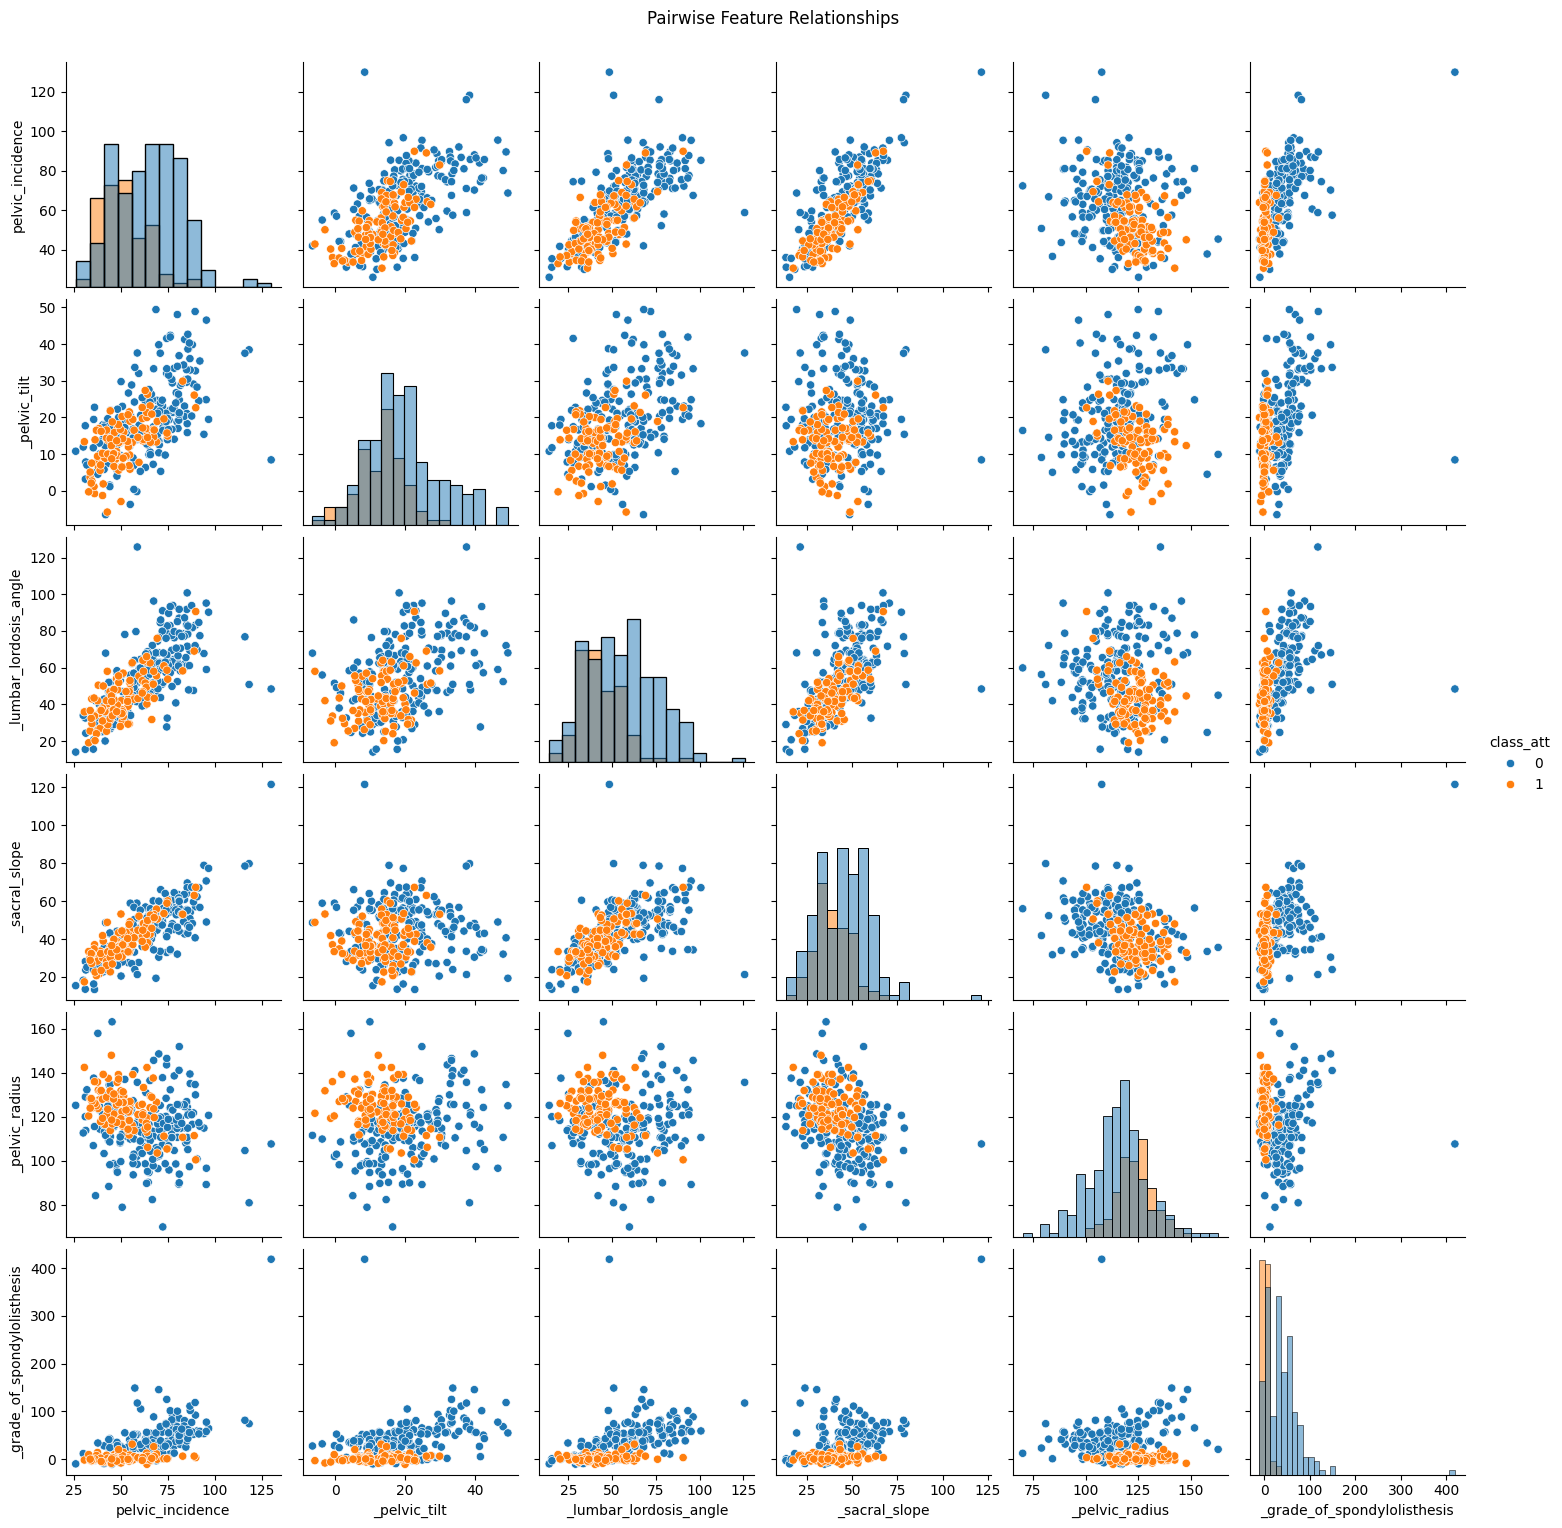

In [14]:
sns.pairplot(df, hue='class_att', diag_kind='hist')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()

Scatter plots for pairs of features that are highly correlated or important for classification.

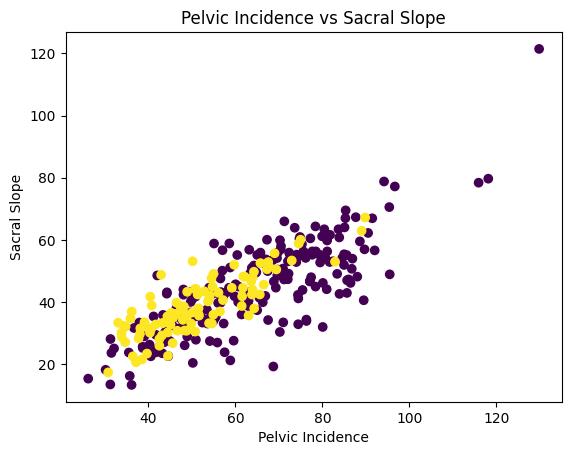

In [15]:
plt.scatter(df['pelvic_incidence'], df['_sacral_slope'], c=df['class_att'])
plt.xlabel('Pelvic Incidence')
plt.ylabel('Sacral Slope')
plt.title('Pelvic Incidence vs Sacral Slope')
plt.show()

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Save to disk
with open('./data/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('./data/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('./data/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('./datay_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [2]:
with open('./data/X_train.pkl', 'rb') as f_in:
    X_train = pickle.load(f_in)

with open('./data/X_test.pkl', 'rb') as f_in:
    X_test = pickle.load(f_in)

with open('./data/y_train.pkl', 'rb') as f_in:
    y_train = pickle.load(f_in)

with open('./data/y_test.pkl', 'rb') as f_in:
    y_test = pickle.load(f_in)

In [ ]:
with mlflow.start_run():
    # Log environment info
    mlflow.log_param("pip_version", pip.__version__)
    
    # Tagging and params
    mlflow.set_tags({
        "model": "logistic_regression",
        "framework": "scikit-learn"
    })
    mlflow.log_params({
        'train_data_path': './data/X_train.pkl',
        'test_data_path': './data/X_test.pkl',
        'model_type': 'LogisticRegression'
    })

    # Model training
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    
    # Predictions
    y_pred = log_reg.predict(X_test)
    y_proba = log_reg.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_auc": roc_auc_score(y_test, y_proba),
        "test_f1": f1_score(y_test, y_pred)
    }
    mlflow.log_metrics(metrics)

    # Get sample input/output for signature
    input_example = X_train[:1]
    signature = infer_signature(X_train, y_pred)

    # Modern model logging (no warnings)
    mlflow.sklearn.log_model(
        sk_model=log_reg,
        name="logistic_regression_model",  # Replaces artifact_path
        signature=signature,
        input_example=input_example,
        registered_model_name="Spine_Disease_Classifier"  # Optional for model registry
    )

    #mlflow.log_artifact("requirements.txt")  # Log your environment
    mlflow.log_param("sklearn_version", sklearn.__version__)

2025/07/23 20:32:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 20:32:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
